In [1]:
import pickle

with open('my_dataset.pickle', 'rb') as data:
    dataset = pickle.load(data)

In [25]:
feature = []
labels = []

In [26]:
def subtract(a, b):
    return (a[0]-b[0], a[1]-b[1])

In [27]:
def features(landmark):
    f1 = ( (landmark[41][0] + landmark[40][0])/2, (landmark[41][1] + landmark[40][1])/2)
    f2 = ( (landmark[38][0] + landmark[37][0])/2, (landmark[37][1] + landmark[38][1])/2)
    f3 = landmark[36]
    f4 = landmark[39]
    f5 = ( (landmark[44][0] + landmark[43][0])/2, (landmark[44][1] + landmark[43][1])/2)
    f6 = ( (landmark[47][0] + landmark[46][0])/2, (landmark[47][1] + landmark[46][1])/2)
    f7 = landmark[42]
    f8 = landmark[45]
    f9 = landmark[33]
    f10 = landmark[17]
    f11 = landmark[21]
    f12 = landmark[19]
    f13 = landmark[22]
    f14 = landmark[26]
    f15 = landmark[24]
    f16 = landmark[48]
    f17 = landmark[54]
    f18 = ( (landmark[62][0] + landmark[66][0])/2, (landmark[62][1] + landmark[66][1])/2)
    
    V1 = subtract(f1, f2)
    V2 = subtract(f4, f3)
    V3 = subtract(f5, f6)
    V4 = subtract(f8, f7)
    V5 = subtract(f11, f10)
    V6 = subtract(f14, f13)
    V7 = subtract(f17, f16)
    V8 = subtract(f12, f1)
    V9 = subtract(f15, f5)
    V10 = subtract(f9, f18)
    V11 = subtract(f2, f16)
    V12 = subtract(f6, f17)
    
    #arr = [V1, V2, V3, V4, V5, V6, V7, V8, V9, V10, V11, V12]
    arr = []
    
    arr = landmark
    return arr

In [28]:
for landmark, label in dataset:
    vect = features(landmark)
    feature.append(vect)
    labels.append(label)

In [29]:
import numpy as np

feature_arr = np.array(feature)
feature_arr.shape

(13811, 68, 2)

In [30]:
from sklearn.svm import SVC
# For scoring
from sklearn.metrics import confusion_matrix, accuracy_score

In [31]:
features_arr_reshape = feature_arr.reshape(feature_arr.shape[0], -1)
features_arr_reshape.shape

(13811, 136)

In [32]:
from sklearn.utils import shuffle
X, y = shuffle(features_arr_reshape, labels, random_state=5)
y = np.array(y)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=5)

y_train.shape

(9253,)

In [33]:
classifier = SVC(kernel = 'linear', random_state = 5)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix : ')
print(cm)
print()

Confusion Matrix : 
[[460  35  18   5  29  40  73]
 [ 39 421  59   3  32  31   4]
 [ 34  52 523  16   9  36   5]
 [ 24   5  16 647   0   3   1]
 [ 37  51   7   5 528  62  14]
 [ 48  36  29   8  62 478   9]
 [ 92  11   5   0  12   5 439]]



In [34]:
acc = accuracy_score(y_test,y_pred)
print("Training Model with only frequency domain features with Data Augmentation :")
print("Accuracy of model :", round(acc*100, 2), "%")

Training Model with only frequency domain features with Data Augmentation :
Accuracy of model : 76.7 %


In [35]:
import os
from PIL import Image
import cv2
import dlib
import numpy as np
import matplotlib.pyplot as plt

In [36]:
emotion = {
    '0' : 'Afraid',
    '1' : 'Angry',
    '2' : 'Disgust',
    '3' : 'Happy',
    '4' : 'Neutral',
    '5' : 'Sad',
    '6' : 'Surprise'
}

In [37]:
# General Cell that initializes the Module Path

Model_PATH = "dlib_trial_weights.dat"
frontalFaceDetector = dlib.get_frontal_face_detector()
faceLandmarkDetector = dlib.shape_predictor(Model_PATH)

In [15]:
with open('my_model.pickle', 'rb') as data:
    classifier = pickle.load(data)

In [42]:
def VideoFeed():
    
    cap = cv2.VideoCapture(0)
    cap.release()
    cap.release()
    cap = cv2.VideoCapture(0)
    
    while True:
        ret, frame = cap.read()
        img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        #Detecting Frontal Face
        faces_detected = frontalFaceDetector(img, 0)
        faces_count = len(faces_detected)
        
        if faces_count==0:
            continue
        
        allLandmarks = []
        flag = 0
        # Iterating each faced detected
        for i in range(0, faces_count):
            rectangle = dlib.rectangle(int(faces_detected[i].left()), int(faces_detected[i].top()), int(faces_detected[i].right()), int(faces_detected[i].bottom()))
            landmarks = faceLandmarkDetector(img, rectangle)
            if landmarks.num_parts == 68:
                for j in range(0,68):
                    cv2.circle(img,(landmarks.part(j).x ,landmarks.part(j).y), 2, (0,255,0), -1)
                    allLandmarks.append((landmarks.part(j).x, landmarks.part(j).y))
                flag=1
                break
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        if(flag==1):
            x_temp = features(allLandmarks)
            x_temp = np.array(x_temp)
            x_temp = x_temp.reshape(1, x_temp.shape[0]*2)
            #print(x_temp.shape)
            pred = classifier.predict(x_temp)
            
            font = cv2.FONT_HERSHEY_SIMPLEX
            fontScale = 2
            thickness = 3
            color = (127, 0, 255)
            a = 50
            b = 50
            pos = (a, b)
            img = cv2.putText(img, emotion[str(pred[0])], pos, font, fontScale, color, thickness, cv2.LINE_AA)
        cv2.imshow("Landmark",img)
        
        if(cv2.waitKey(2) == 13 & 0xFF):
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.imshow(img)
            break
    cap.release()
    cv2.destroyAllWindows()

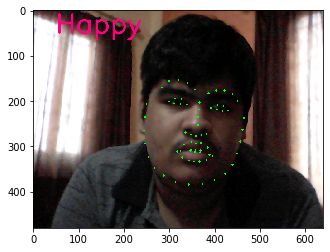

In [43]:
VideoFeed()

In [18]:
# import pickle

# with open('my_model.pickle', 'wb') as output:
#     pickle.dump(classifier, output)

In [19]:
# with open('my_model.pickle', 'rb') as data:
#     classifier = pickle.load(data)